# Quickstart

This notebook demonstrates how you can find adversarial examples for a pre-trained example network on the MNIST dataset.

We suggest having the `Gurobi` solver installed, since its performance is significantly faster. If this is not possible, the `Cbc` solver is another option.

The `Images` package is only necessary for visualizing the MNIST images.

In [1]:
using MIPVerify
using Gurobi
using Images

## Setup

### MNIST dataset

We begin by loading the MNIST dataset. The data is provided as a Julia `struct` for easy access. The training images and test images are provided as a 4-dimensional array of size `(num_samples, height, width, num_channels)`.

In [2]:
mnist = MIPVerify.read_datasets("MNIST")

MNIST:
  `train`: {ImageDataset}
    `images`: 55000 images of size (28, 28, 1), with pixels in [0.0, 1.0].
    `labels`: 55000 corresponding labels, with 10 unique labels in [0, 9].
  `test`: {ImageDataset}
    `images`: 10000 images of size (28, 28, 1), with pixels in [0.0, 1.0].
    `labels`: 10000 corresponding labels, with 10 unique labels in [0, 9].

In [3]:
mnist.train

{ImageDataset}
    `images`: 55000 images of size (28, 28, 1), with pixels in [0.0, 1.0].
    `labels`: 55000 corresponding labels, with 10 unique labels in [0, 9].

In [4]:
size(mnist.train.images)

(55000, 28, 28, 1)

We can use `Images.colorview` to preview these images. 

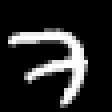

In [5]:
colorview(Gray, mnist.train.images[1, :, :, 1])

In [6]:
mnist.train.labels

55000-element Array{Int64,1}:
 7
 3
 4
 6
 1
 8
 1
 0
 9
 8
 0
 3
 1
 ⋮
 7
 8
 9
 2
 9
 5
 1
 8
 3
 5
 6
 8

### Sample Neural Network

We import a sample pre-trained neural network. 

In [7]:
n1 = MIPVerify.get_example_network_params("MNIST.n1")

sequential net MNIST.n1
  (1) Flatten(): flattens 4 dimensional input, with dimensions permuted according to the order [4, 3, 2, 1]
  (2) Linear(784 -> 40)
  (3) ReLU()
  (4) Linear(40 -> 20)
  (5) ReLU()
  (6) Linear(20 -> 10)


`MIPVerify.frac_correct` allows us to verify that the network has a reasonable accuracy on the test set of 96.95%. (This step is crucial when working with your own neural net parameters; since the training is done outside of Julia, a common mistake is to transfer the parameters incorrectly.)

In [8]:
MIPVerify.frac_correct(n1, mnist.test, 10000)

0.9695

We feed the first image into the neural net, obtaining the activations of the final softmax layer. 

Note that the image must be specified as a 4-dimensional array with size `(1, height, width, num_channels)`. We provide a helper function `MIPVerify.get_image` that extracts the image from the dataset while preserving all four dimensions.

In [9]:
sample_image = MIPVerify.get_image(mnist.train.images, 1)

1×28×28×1 Array{Float32,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

...

[:, :, 26, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 27, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 28, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [10]:
output_activations = sample_image |> n1

10-element Array{Float32,1}:
 0.15597 
 0.270125
 1.49147 
 0.145112
 0.281066
 0.385918
 0.228231
 4.10202 
 0.905381
 1.15467 

The category that has the largest activation is category 8, corresponding to a label of 7.

In [11]:
(output_activations |> MIPVerify.get_max_index) - 1

7

This matches the true label.

In [12]:
MIPVerify.get_label(mnist.train.labels, 1)

7

## Finding an Adversarial Example

We now try to find an adversarial example for the first image on `n1`, setting the target category as index `9` (corresponding to a true label of 8).

In [13]:
target_label_index = 9
d = MIPVerify.find_adversarial_example(n1, sample_image, target_label_index, GurobiSolver())

[notice | MIPVerify]: Loading model from cache.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [9]
Optimize a model with 3385 rows, 3256 columns and 71132 nonzeros
Variable types: 3196 continuous, 60 integer (60 binary)
Coefficient statistics:
  Matrix range     [2e-05, 7e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+02]
  RHS range        [1e-02, 7e+02]
Presolve removed 2860 rows and 2184 columns
Presolve time: 0.12s
Presolved: 525 rows, 1072 columns, 65472 nonzeros

MIP start did not produce a new incumbent solution
MIP start violates constraint R784 by 70.892854817

Variable types: 1012 continuous, 60 integer (60 binary)

Root relaxation: objective 0.000000e+00, 241 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    9          -    0.00000 

Dict{Symbol,Any} with 7 entries:
  :PerturbationParameters => additive
  :TargetIndexes          => [9]
  :SolveStatus            => :Optimal
  :Output                 => JuMP.GenericAffExpr{Float64,JuMP.Variable}[-0.0120…
  :Model                  => Minimization problem with:…
  :Perturbation           => JuMP.Variable[__anon__ __anon__ __anon__ __anon__ …
  :PerturbedInput         => JuMP.Variable[__anon__ __anon__ __anon__ __anon__ …

In [14]:
using JuMP

perturbed_sample_image = getvalue(d[:PerturbedInput])

1×28×28×1 Array{Float64,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

...

[:, :, 26, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 27, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 28, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

As a sanity check, we feed the perturbed image into the neural net and inspect the activation in the final layer. We verify that the perturbed image does maximize the activation of the target label index, which is 9.

In [15]:
perturbed_sample_image |> n1

10-element Array{Float64,1}:
 0.257004
 0.416757
 0.692725
 0.38037 
 0.295063
 0.204749
 0.488696
 3.30817 
 3.30817 
 0.551406

We visualize the perturbed image and compare it to the original image. Since we are minimizing the L1-norm, changes are made to only a few pixels, but the magnitude of these changes are large (and noticeable).

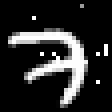

In [16]:
colorview(Gray, perturbed_sample_image[1, :, :, 1])

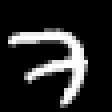

In [17]:
colorview(Gray, sample_image[1, :, :, 1])

That concludes this quickstart! The next tutorial will introduce you to each of the layers, and show how you can import your own neural network parameters.